# Loading data

In [22]:
# imports
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from typing import Dict, Any, List
import pickle
from sklearn.model_selection import train_test_split

In [2]:
def convert_to_binary(label: Any) -> int:
    """
    Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
    """
    # If label_array is a string, convert it to a list
    return 0 if label == 0 or label == 1 else 1 

In [5]:
TRAIN_DATA_PATH = "data/dontpatronizeme_pcl.tsv"
TRAIN_ALLOC_PATH = "data/train_semeval_parids-labels.csv"
DEV_ALLOC_PATH = "data/dev_semeval_parids-labels.csv"

column_names = ["par_id", "art_id", "keyword", "country", "text", "orig_label"]
text_data = pd.read_csv(TRAIN_DATA_PATH, sep="\t", header=None, names=column_names)
text_data["label"] = text_data["orig_label"].apply(convert_to_binary)

print("Text Data shape:", text_data.shape)

train_alloc = pd.read_csv(TRAIN_ALLOC_PATH).drop("label", axis=1)
official_dev_alloc = pd.read_csv(DEV_ALLOC_PATH).drop("label", axis=1)
print("Train Allocation shape:", train_alloc.shape)
print("Official Dev Allocation shape:", official_dev_alloc.shape)

train_data = pd.merge(train_alloc, text_data, on="par_id")
official_dev_data = pd.merge(official_dev_alloc, text_data, on="par_id")
print("Merged Train Data shape:", train_data.shape)
print("Merged Official Dev Data shape:", official_dev_data.shape)

Text Data shape: (10469, 7)
Train Allocation shape: (8375, 1)
Official Dev Allocation shape: (2094, 1)
Merged Train Data shape: (8375, 7)
Merged Official Dev Data shape: (2094, 7)


### (Pre-)Tokenise Dataset

### Load into DataLoader

In [18]:
class DontPatronizeMeDataset(Dataset):
  def __init__(self, data, tokenizer = None, max_length=128):
    self.tokenizer = tokenizer

    if self.tokenizer is not None:
      self.max_length = max_length
      self.data = data.reset_index(drop = True)
    else:
      self.data = data

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
    if self.tokenizer is not None:
      text = str(self.data.loc[idx, "text"])
      label = self.data.loc[idx, "label"]

      encoding = self.tokenizer(
        text, 
        add_special_tokens=True,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
      )

      encoding = { key: value.squeeze(0) for key, value in encoding.items() }
      encoding["labels"] = torch.tensor(label, dtype=torch.long)

      return encoding
    else:
      item = self.data[idx]
      item.pop("text", None)
      return item

In [23]:
with open("pretokenized.pkl", "rb") as f:
  pretokenized_data = pickle.load(f)

labels = [int(item["labels"]) for item in pretokenized_data]

internal_train_data, internal_test_data = train_test_split(
  pretokenized_data,
  test_size = 0.2,
  random_state = 16,
  stratify=labels
)

train_dataset = DontPatronizeMeDataset(internal_train_data)
test_dataset = DontPatronizeMeDataset(internal_test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Data analysis

In [24]:
# imports
import matplotlib.pyplot as plt
from collections import Counter

### Check class imbalance

--- Train ---
{0: 6065, 1: 635}
{0: '90.52%', 1: '9.48%'}
--- Test ---
{0: 1516, 1: 159}
{0: '90.51%', 1: '9.49%'}


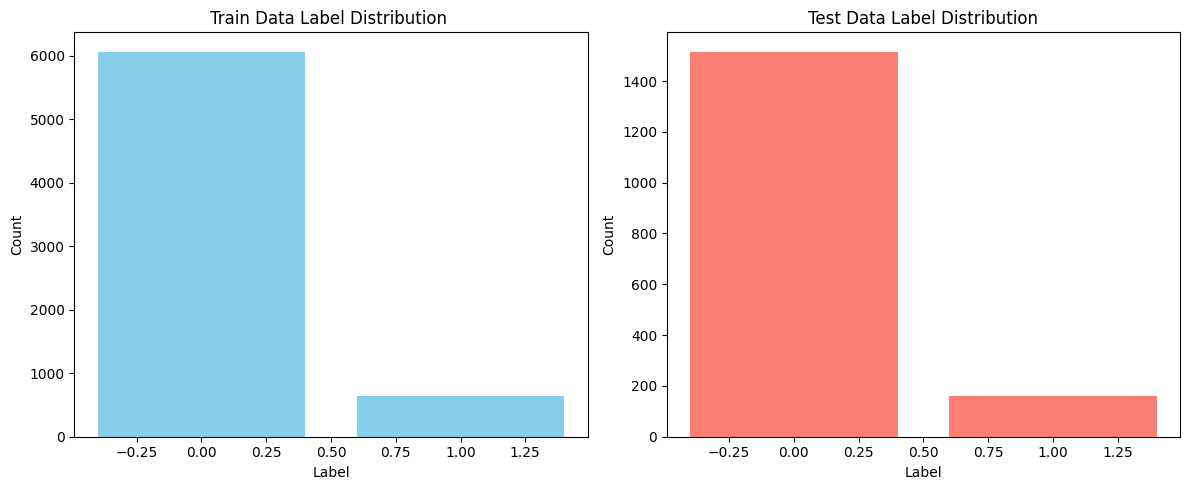

In [27]:
def check_class_imbalance(train_data, test_data, with_aug=False):
  train_labels = [int(item["labels"]) for item in train_data]
  test_labels = [int(item["labels"]) for item in test_data]

  train_counts = Counter(train_labels)
  test_counts = Counter(test_labels)

  train_sorted = { k : v for k, v in sorted(train_counts.items()) }
  test_sorted = { k : v for k, v in sorted(test_counts.items()) }

  print("--- Train ---")
  print(train_sorted)
  train_total = sum(train_counts.values())
  print({ k: f"{(100 * v / train_total):.2f}%" for k, v in train_sorted.items() })

  print("--- Test ---")
  print(test_sorted)
  test_total = sum(test_counts.values())
  print({ k: f"{(100 * v / test_total):.2f}%" for k, v in test_sorted.items() })

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

  axes[0].bar(list(train_sorted.keys()), list(train_sorted.values()), color='skyblue')
  axes[0].set_title(f'Train Data Label Distribution {"(with Data Augmentation)" if with_aug else ""}')
  axes[0].set_xlabel('Label')
  axes[0].set_ylabel('Count')

  axes[1].bar(list(test_sorted.keys()), list(test_sorted.values()), color='salmon')
  axes[1].set_title(f'Test Data Label Distribution')
  axes[1].set_xlabel('Label')
  axes[1].set_ylabel('Count')

  plt.tight_layout()
  plt.show()
  
check_class_imbalance(internal_train_data, internal_test_data)